In [1]:
import os
import numpy as np
import scipy.io as sio
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from mrspy.plot import plot

In [2]:
def complex2ri(x):  # x: (H,W) complex or (...,1) complex -> (2,H,W) float
    if np.iscomplexobj(x):
        return np.stack([np.real(x), np.imag(x)], axis=0).astype(np.float32)
    # already real?
    x = np.asarray(x)
    return np.stack([x, np.zeros_like(x)], axis=0).astype(np.float32)

def ri2complex(x):  # x: (2,H,W) -> (H,W) complex
    return x[0] + 1j * x[1]

# ----------------------------
# Dataset (complex path)
# - Mimics your TF getBatch_complex() logic per-sample
# ----------------------------
class SPENComplexDataset(Dataset):
    """
    Loads:
      - spendata_train/HCP_0307_train.mat (expects 'ImagAll' -> (N,H,W) complex or real)
      - A_AH_CP120/A_AH_1_CP120.mat (expects 'AFinal' and 'AWhole' like your code)
    Returns per item (like getBatch_complex):
      real_F:   (2,H,W)  # complex image F (normalized)
      real_D:   (2,H,W)  # k-space downsampled via A, returned as complex (real/imag channels)
      real_D_F: (2,H,W)  # original D as complex channels (before A)
      A:        (H,W) complex64 (if you need it in the model; otherwise you can drop it)
    """
    def __init__(self, data_root):
        super().__init__()
        self.data_root = data_root
        self.train_mat = os.path.join(data_root, "spendata_train", "HCP_0307_train.mat")
        self.A_file = os.path.join(data_root, "A_AH_CP120", "A_AH_1_CP120.mat")

        # Load training data
        m = sio.loadmat(self.train_mat, verify_compressed_data_integrity=False)
        X = m["ImagAll"]  # (N,H,W) complex is ideal; sometimes saved as 2 channels—handle both
        if X.ndim == 3:  # assume complex (N,H,W)
            self.X = X
        elif X.ndim == 4 and X.shape[-1] == 2:  # saved as (N,H,W,2) real/imag
            self.X = X[...,0] + 1j * X[...,1]
        else:
            raise ValueError("Unsupported ImagAll shape")

        # Load A and AH
        a = sio.loadmat(self.A_file, verify_compressed_data_integrity=False)
        # In your TF code:
        #   A  = 'AFinal'  (used as forward encoding on D^T then transposed back)
        #   AH = 'AWhole'  (used as adjoint on F to synthesize D->F)
        self.A  = a["AFinal"]   # (H,W) complex
        self.AH = a["AWhole"]   # (H,W) complex

        # Sanity
        self.X = self.X.astype(np.complex64)
        self.A  = self.A.astype(np.complex64)
        self.AH = self.AH.astype(np.complex64)

        # Normalize per-volume later (per-sample like your TF)
        self.N, self.H, self.W = self.X.shape

    def __len__(self):
        return self.N

    def __getitem__(self, idx):
        # aInput_F in TF (complex image)
        F = self.X[idx]  # (H,W) complex
        F = F / (np.abs(F).max() + 1e-8)

        # aInput_D: in TF they start from a second shuffled source; for a minimal demo
        # we’ll just reuse F as "D source". If you want exactly the TF behavior,
        # build a second dataset and zip() two DataLoaders.
        D_src = F.copy()

        # real_D_F: D_src as 2-channel
        real_D_F = complex2ri(D_src)  # (2,H,W)

        # k_down_D = transpose( dot( transpose(D_src), A) ), then normalize
        # Shapes: D_src: (H,W), A: (H,W)
        # emulate: k_down_D = (D_src^T @ A)^T
        k_down_D = (D_src.T @ self.A).T
        k_down_D = k_down_D / (np.abs(k_down_D).max() + 1e-8)

        # Pack as (2,H,W)
        real_D = complex2ri(k_down_D)
        real_F = complex2ri(F)

        # Return A as complex (H,W); your model can convert or ignore as needed
        A = self.A  # (H,W) complex

        sample = {
            "real_F": torch.from_numpy(real_F),         # float32, (2,H,W)
            "real_D": torch.from_numpy(real_D),         # float32, (2,H,W)
            "real_D_F": torch.from_numpy(real_D_F),     # float32, (2,H,W)
            "A": torch.from_numpy(np.stack([np.real(A), np.imag(A)], axis=0)).float()  # (2,H,W) real/imag
        }
        return sample


data_root = "/home/data1/musong/workspace/2025/8/08-20/nxz/Data/mat"

dataset = SPENComplexDataset(data_root)

In [3]:
demo_data = dataset[0]

In [4]:
demo_data['real_F'].shape

torch.Size([2, 96, 96])

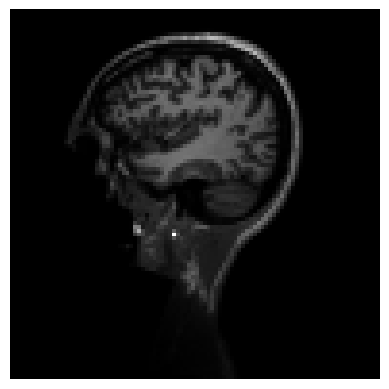

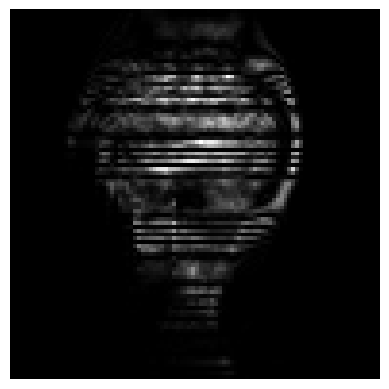

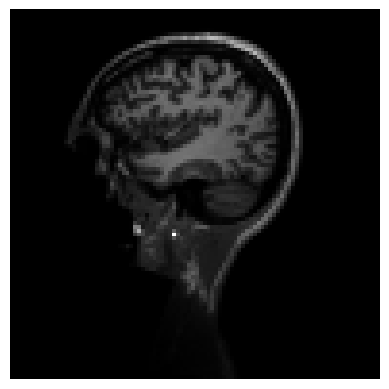

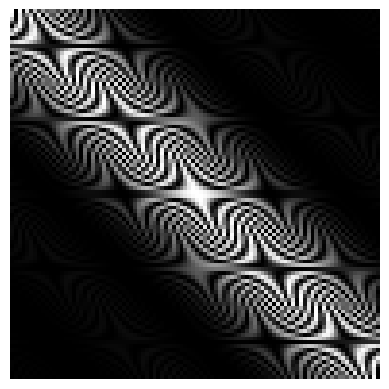

In [5]:
plot(demo_data['real_F'][0] ** 2 + demo_data['real_F'][0] ** 2)
plot(demo_data['real_D'][0] ** 2 + demo_data['real_D'][0] ** 2)
plot(demo_data['real_D_F'][0] ** 2 + demo_data['real_D_F'][0] ** 2)
plot(demo_data['A'][0] ** 2 + demo_data['A'][0] ** 2)

In [ ]:
temp_a = sio.loadmat("/home/data1/musong/workspace/2025/8/08-20/nxz/real_data/rat/RAT_train_1000_org.mat", verify_compressed_data_integrity=False)

In [ ]:
print(temp_a.keys())

print(temp_a['AFinal'].shape)
print(temp_a['AWhole'].shape)
print(temp_a['ImagAll'].shape)
print(temp_a['blur'].shape)
# print(temp_a['recon'].shape)

dict_keys(['__header__', '__version__', '__globals__', 'AFinal', 'AWhole', 'ImagAll', 'blur', 'deBlur'])
(96, 96)
(96, 96)
(1000, 96, 96)
(1000, 96, 96)


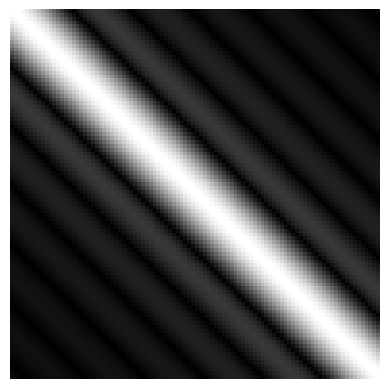

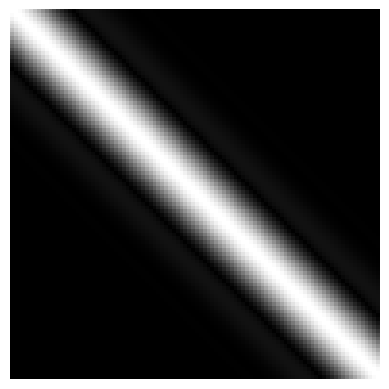

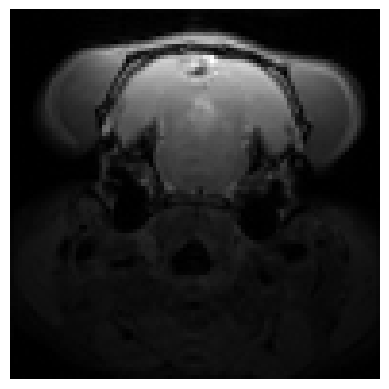

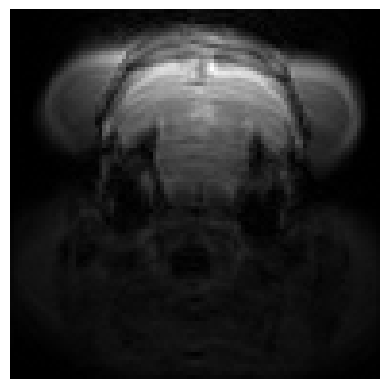

In [ ]:
plot(np.abs(temp_a['AFinal']))
plot(np.abs(temp_a['AWhole']))
plot(np.abs(temp_a['ImagAll'][0]))
plot(np.abs(temp_a['blur'][0]))
# plot(np.abs(temp_a['recon'].transpose((2, 0, 1))[0]))